# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 4b
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

#### (b) Please design an autoencoder only for digits 1, 3, 5, 7 in MNIST. Then use the trained autoencoder to detect anomaly data that is not in the set of 1, 3, 5, 7.

## Create Dataset

Number of training samples: 14312
Number of validation samples: 35000
Number of testing samples: 35000

Label: 1.0


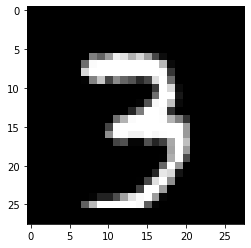

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from utils import anomaly_detect_split, AnomalyValidation

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))
# Normalize pixel values to be between 0 and 1
images = images / 255.0

(
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    test_images, 
    test_labels
) = anomaly_detect_split(images, labels)

print(f'Number of training samples: {train_labels.shape[0]}')
print(f'Number of validation samples: {val_labels.shape[0]}')
print(f'Number of testing samples: {test_labels.shape[0]}')

ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_images)).cache().shuffle(train_labels.shape[0]).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((val_images, val_images)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tf.data.Dataset.from_tensor_slices((test_images, test_images)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)

print()
plt.imshow(train_images[0], cmap='gray')
print(f'Label: {train_labels[0]}')

## Model Design

In [2]:
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(4, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(8, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.ZeroPadding2D(((1, 2), (1, 2))),
    tf.keras.layers.Conv2DTranspose(4, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Reshape((28, 28))
])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 16)          1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 32)          1

## Training

In [3]:
LR = 1e-3
ATH = 0.04 # anomaly confidence threshold

In [4]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='mse',
)
history = autoencoder.fit(
    ds_train, 
    epochs=100,
    verbose=0,
    callbacks=[AnomalyValidation(ATH, ds_val, 10)]
)
# AnomalyValidation callback: Perform anomaly detect on validation dataset
#                             Save the best weights and set the weight in training end

Epoch  1 Train  MSE:  0.076, 	Anomaly detection accuracy:  0.04326
Epoch 11 Train  MSE:  0.020, 	Anomaly detection accuracy:  0.83706
Epoch 21 Train  MSE:  0.017, 	Anomaly detection accuracy:  0.93809
Epoch 31 Train  MSE:  0.015, 	Anomaly detection accuracy:  0.96646
Epoch 41 Train  MSE:  0.015, 	Anomaly detection accuracy:  0.97583
Epoch 51 Train  MSE:  0.014, 	Anomaly detection accuracy:  0.98346
Epoch 61 Train  MSE:  0.014, 	Anomaly detection accuracy:  0.98826
Epoch 71 Train  MSE:  0.013, 	Anomaly detection accuracy:  0.99020
Epoch 81 Train  MSE:  0.013, 	Anomaly detection accuracy:  0.99154
Epoch 91 Train  MSE:  0.013, 	Anomaly detection accuracy:  0.99266


## Inference

In [5]:
num_correct = 0
num_total = 0
for image, label in ds_test:
    num_correct += (tf.keras.losses.MSE(autoencoder(image), image).numpy().mean(axis=1) < ATH).sum()
    num_total += label.shape[0]
print(f'Anomaly detection accuracy: {num_correct/num_total: .5f}')

Anomaly detection accuracy:  0.99337
